# Stable Diffusion Loop

More insight into the simple function behind `pipe("a cat running in the sky")`.

In [3]:
!pip install -q --upgrade transformers diffusers ftfy

In [9]:
from huggingface_hub import notebook_login
from pathlib import Path
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [10]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## loading vaious models

In [12]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

## The Loop

0it [00:00, ?it/s]

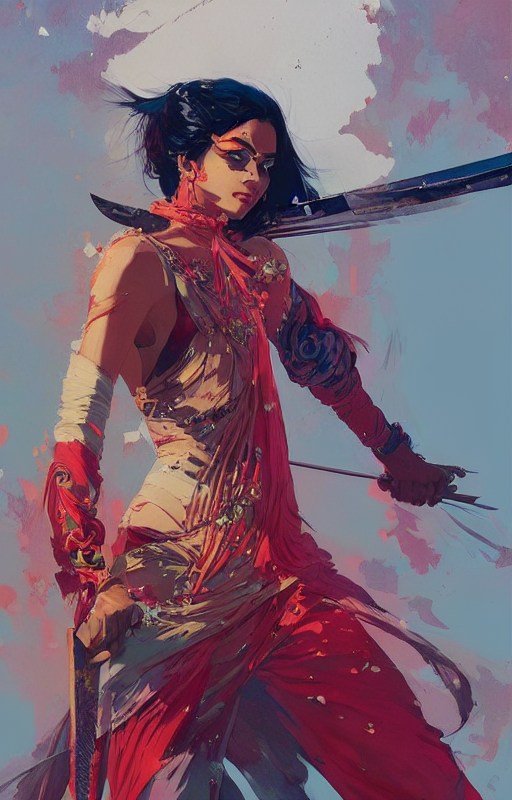

In [59]:
# Some settings
prompt = ["a ultradetailed beautiful panting of a stylish indian woman with a sword, by conrad roset, greg rutkowski and makoto shinkai, trending on artstation"]
height = 800                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 100            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]